In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [6]:
# #############################################################################
# Load data
# Boston house-prices dataset (regression)

#TO DO - test on more datasets if variance within the algorithm is negligble
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [6]:
# #############################################################################
# Fit regression model
# n_estimators : int (default=100) The number of boosting stages to perform.
# learning_rate : float, optional (default=0.1) learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
# max_depth : integer, optional (default=3) maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
# min_samples_split : int, float, optional (default=2) The minimum number of samples required to split an internal node
# loss : (default=’ls’) loss function to be optimized. ‘ls’ refers to least squares regression.

pred_y_all = []

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
for i in range(10):
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    pred_y_i = clf.predict(X_test)
    pred_y_all.append(pred_y_i)
    mse = mean_squared_error(y_test, pred_y_i)
    print("MSE: %.4f" % mse)

MSE: 9.8826
MSE: 10.0895
MSE: 9.8977
MSE: 9.7963
MSE: 9.6880
MSE: 9.7426
MSE: 10.1237
MSE: 10.0916
MSE: 9.8951
MSE: 9.7073


In [9]:
np.corrcoef(pred_y_all[1], pred_y_all[2])


array([[ 1.        ,  0.99993081],
       [ 0.99993081,  1.        ]])

Text(0, 0.5, 'Deviance')

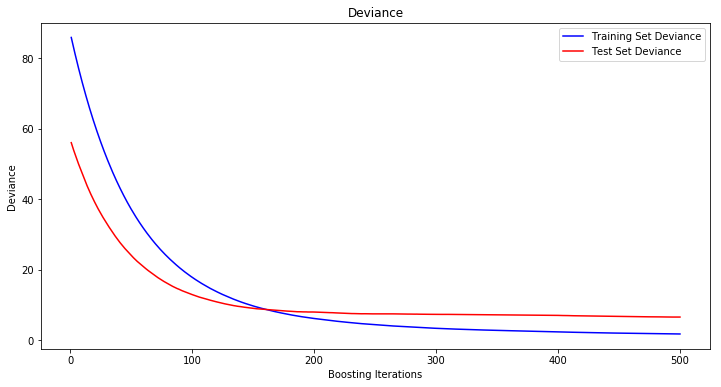

In [6]:
# #############################################################################
# Plot training deviance

# The figure below shows the results of applying GradientBoostingRegressor with least squares loss and 500 base learners 
# to the Boston house price dataset (sklearn.datasets.load_boston). It shows the train and test error at each 
# iteration. The train error at each iteration is stored in the train_score_ attribute of the gradient boosting model. The test 
# error at each iterations can be obtained via the staged_predict method which returns a generator that yields the predictions 
# at each stage. Plots like these can be used to determine the optimal number of trees (i.e. n_estimators) by early stopping.

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [29]:
# TO DO -- compare y_pred of another python boosting implementation
# for e.g. here - https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm 

class LeastSquaresRegression(object):
    def __init__(self):
        self.weights = []
    
    def calcLeastSquares(self, X, y):
        xtranspose = np.transpose(X)
        xtransx = np.dot(xtranspose, X)
        if xtransx.shape[0] != xtransx.shape[1]:
            raise ValueError('Needs to be a square matrix for inverse')
        matinv = np.linalg.inv(xtransx)
        xtransy = np.dot(xtranspose, y)
        self.weights = np.dot(matinv, xtransy)

    def makePredictions(self, X):
        class_output = np.dot(X, self.weights)
        return np.sign(class_output)

class Boosting(object):

    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.N = self.X_train.shape[0]
        self.y_train = y_train
        self.weights = np.ones(self.N)/self.N
        self.epsilont = []
        self.alphas = []
        self.classifiers = []
        self.histogram = {}
        #self.num_estimators = T
        
    def doBoosting(self):
#         for t in range(self.num_estimators):
        for t in range(3500):
            output = np.random.choice(self.N, self.N, p=self.weights)
            
            for t in output:
                self.histogram[t] = self.histogram.get(t, 0) + 1
            
#             print output
            B_Xtrain = self.X_train[output]
            B_ytrain = self.y_train[output]
        
            ls = LeastSquaresRegression()
            ls.calcLeastSquares(B_Xtrain, B_ytrain)
#             print ls.weights
            Y_pred = ls.makePredictions(self.X_train)
            
#             print Y_pred
            
            e_t = np.sum((Y_pred != self.y_train) * self.weights)
#             print e_t
            if e_t > 0.5:
                ls.weights = -ls.weights
                Y_pred = ls.makePredictions(self.X_train)
                e_t = np.sum((Y_pred != self.y_train) * self.weights)
            
#             print e_t
            self.epsilont.append(e_t)

            alpha_t = 0.5 * np.log((1 - e_t)/e_t)
            self.alphas.append(alpha_t)
            self.classifiers.append(ls)
            
#             print alpha_t   
            self.weights = self.weights * np.exp(-alpha_t* Y_pred * self.y_train)
            self.weights = self.weights / np.sum(self.weights)

In [30]:
X_train = np.genfromtxt('boosting/X_train.csv', delimiter=',')
y_train = np.genfromtxt('boosting/y_train.csv')
X_test = np.genfromtxt('boosting/X_test.csv', delimiter=',')
y_test = np.genfromtxt('boosting/y_test.csv')

def append_column_one(data):    
    append_ones = np.ones((data.shape[0],1))
    data = np.hstack((append_ones, data))
    return data

X_train = append_column_one(X_train)
X_test = append_column_one(X_test)


In [31]:
training_error = []
testing_error = []

boost = Boosting(X_train, y_train)
boost.doBoosting()

for t in tqdm(range(1, 1501)):
    sum_train = np.zeros(X_train.shape[0])
    sum_test = np.zeros(X_test.shape[0])
    for i in range(t):
        alpha = boost.alphas[i]
        classifier = boost.classifiers[i]
#             print X_train.shape
#             print classifier.weights.shape
#             print np.dot(X_train, classifier.weights).shape
        sum_train += (alpha * classifier.makePredictions(X_train))
        sum_test += (alpha * classifier.makePredictions(X_test))
    fboost_train_pred = np.sign(sum_train)
    fboost_test_pred = np.sign(sum_test)

    training_error.append(mean_squared_error(y_train, fboost_train_pred))
    testing_error.append(mean_squared_error(y_test, fboost_test_pred))
    #training_error.append(np.sum(fboost_train_pred != y_train)/y_train.shape[0])
    #testing_error.append(np.sum(fboost_test_pred != y_test)/y_test.shape[0])

100%|██████████████████████████████████████| 1500/1500 [00:40<00:00, 20.91it/s]


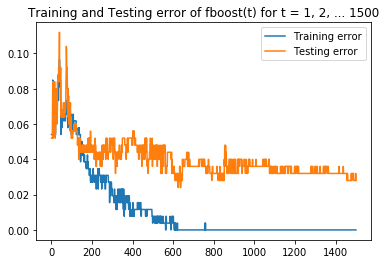

In [32]:
plt.figure()
plt.plot(range(1,1501), training_error, label="Training error")
plt.plot(range(1,1501), testing_error, label="Testing error")
plt.title("Training and Testing error of fboost(t) for t = 1, 2, ... 1500")
plt.legend()
plt.show()

In [33]:
X_train = np.genfromtxt('boosting/X_train.csv', delimiter=',')
y_train = np.genfromtxt('boosting/y_train.csv')
X_test = np.genfromtxt('boosting/X_test.csv', delimiter=',')
y_test = np.genfromtxt('boosting/y_test.csv')

pred_y_all = []

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
for i in range(1):
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)
    pred_y_i = clf.predict(X_test)
    pred_y_all.append(pred_y_i)
    error = mean_squared_error(y_test, pred_y_i)
    print("MSE: %.4f" % mse)

MSE: 0.0298


In [34]:
#correlate here

np.corrcoef(pred_y_i, fboost_test_pred)

array([[ 1.        ,  0.99193904],
       [ 0.99193904,  1.        ]])